# Week4授業前課題1 アヤメを分類しよう

## 【課題1】練習のために特徴量とカテゴリを選択
選び方は合計18通りありますが、以下の組み合わせで練習することにします。irisデータセットをWeek3同様に取得した後、データフレームからこれらを抜き出してください。

* versicolorとvirginica
* sepal_lengthとpetal_length  

実際の問題では？
実際の問題を解く上でも結果の可視化は有効です。しかし、そのために学習や推定に使う特徴量を2つに絞るのは望ましくありません。そのため学習や推定は多次元で行い、可視化をする際にだけ主成分分析などの特徴抽出手法を適用するといったことが行われます。また、Week3で利用した散布図行列を使い可視化することも可能です。

In [27]:
from sklearn.datasets import load_iris
dataset = load_iris()
print(dataset.keys())
print(dataset.target_names)

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])
['setosa' 'versicolor' 'virginica']


In [28]:
import pandas as pd

#import features
x = pd.DataFrame(dataset.data, columns = dataset.feature_names)
x.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [29]:
#import target value
y = pd.DataFrame(dataset.target, columns = {'species'})
y.head()

,species
0,0
1,0
2,0
3,0
4,0


In [30]:
#concatenate x and y
df = pd.concat((x, y), axis=1)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [31]:
#extract only sepal_length and petal_length

#drop  sepal width and petal width columns
df = df.drop([dataset.feature_names[1], dataset.feature_names[3]], axis=1)

#extract only versicolor and virginica
#drop setosa rows(label: 0)
setosa_row = df[df['species'] == 0].index
df = df.drop(setosa_row, axis=0)

In [32]:
df.head()

,sepal length (cm),petal length (cm),species
50,7.0,4.7,1
51,6.4,4.5,1
52,6.9,4.9,1
53,5.5,4.0,1
54,6.5,4.6,1


In [33]:
df.tail()

,sepal length (cm),petal length (cm),species
145,6.7,5.2,2
146,6.3,5.0,2
147,6.5,5.2,2
148,6.2,5.4,2
149,5.9,5.1,2


## 【問題2】データの分析
まずはデータの分析を行いますが、これはWeek3の課題1で行いました。その際出力した散布図行列を見ることで、先ほどの18通りそれぞれの散布図も確認できます。sepal_lengthとpetal_lengthを使い、virgicolorとvirginicaを分類するのは少し難しそうな状況であることが分かるはずです。

ここでは復習を兼ねて、抜き出したデータの散布図と箱ひげ図（boxplot）、バイオリン図（violinplot）を表示してください。

実際の問題では？

このデータ分析の結果を元に前処理として特徴量エンジニアリングを行っていきます。

今回はsepal_lengthとpetal_lengthを抜き出しましたが、分析した上で、問題を少々難しくするための前処理をしたと言えます。

前処理
データに加工をしていきます。

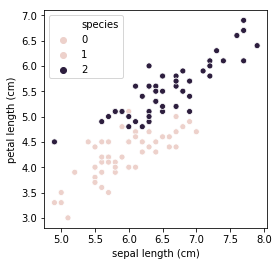

In [34]:
#Scatterplot
import matplotlib.pyplot as plt
import seaborn as sns

fig =plt.figure(figsize=(4, 4))
sns.scatterplot(data =df, x=df.columns[0], y=df.columns[1], hue=df.columns[2]);

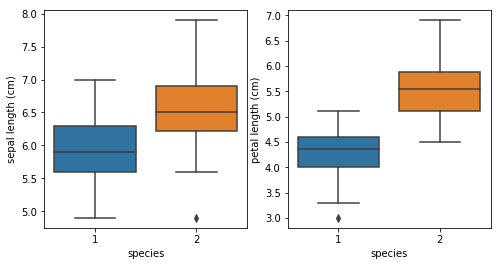

In [35]:
#Boxplot
fig, axes = plt.subplots(1,2, figsize=(8,4))
sns.boxplot(ax=axes[0], data=df, x=df.columns[2], y=df.columns[0]);
sns.boxplot(ax=axes[1], data=df, x=df.columns[2], y=df.columns[1]);
fig.tight_layout;

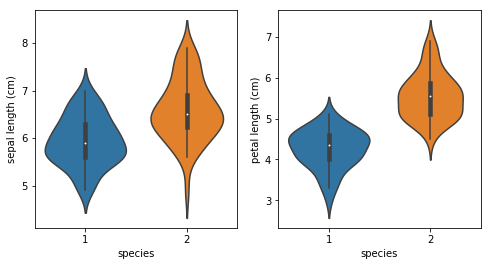

In [36]:
#Violinplot
fig, axes = plt.subplots(1,2, figsize=(8,4));
sns.violinplot(ax=axes[0], data=df, x=df.columns[2], y=df.columns[0]);
sns.violinplot(ax=axes[1], data=df, x=df.columns[2], y=df.columns[1]);
fig.tight_layout;

## 【問題3】前処理・学習用データと検証用データの分割
前処理の一貫として、学習用（train）データと検証用（validation）データの分割を行います。今回は学習用データ75%、検証用データ25%として分割してください。

scikit-learnのtrain_test_splitが利用できます。公式ドキュメントのExamplesを参考に動かしてください。

sklearn.model_selection.train_test_split — scikit-learn 0.20.0 documentation

注意点

データの分析まではPandasのDataFrame型を使用してきました。しかし、scikit-learnはNumPyのndarray型を想定して作られています。そのため、この段階でndarrayへの変換を行いましょう。特徴量（説明変数）をX、正解（目的変数）をyというndarrayに格納します。

分割する理由

分類問題の目的は未知のデータを正しく分類することです。その目的が達成できているかを確認するため、実際には答えの分かっているデータの一部を学習には使わず残しておきます。この学習に使用していないデータで推定を行い、そこから求めた指標値によって検証します。学習に使うデータを学習用データ、検証に使うデータが検証用データで、一般的に7対3から8対2程度の割合にします。

In [37]:
import numpy as np
from sklearn.model_selection import train_test_split

#dataframe to ndarray

X = np.array(df.iloc[:, [0, 1]])
y = np.array(df.iloc[:, 2])

In [38]:
#confirm conversion
print(X[0:5], "\n")
print(y[0:5])

[[7.  4.7]
 [6.4 4.5]
 [6.9 4.9]
 [5.5 4. ]
 [6.5 4.6]] 

[1 1 1 1 1]


In [39]:
#split arrays into two (train, test)
#shuffling is True by default
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=3/4, test_size=1/4)

In [40]:
#confirm if correctly split
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(75, 2)
(25, 2)
(75,)
(25,)


## 【問題4】前処理・標準化
分類精度をあげるための加工を行います。手法ごとに適切な方法は異なりますが、ここでは一例として 標準化 を行うことにします。

標準化を行うライブラリもscikit-learnに用意されています。これを使って標準化してください。

sklearn.preprocessing.StandardScaler — scikit-learn 0.20.2 documentation

注意点

標準化は学習用のデータでfitを行い、学習用、検証用双方のデータにtransformを行います。検証用データは学習の段階には存在しない未知のデータの代わりなので、標準化のための平均や標準偏差の計算に使ってはいけません。

実際の問題での前処理は？

アヤメのデータセットのように綺麗で扱いやすい状況で提供されることはまずありません。分析を行いながら、様々な加工が必要になってきます。例えばWeek3の課題2で行った欠損値の確認の後、場合により欠損値の補間も行います。外れ値の確認や、複数のデータセットの整理などもあります。

In [41]:
from sklearn.preprocessing import StandardScaler

#generate instance
scaler = StandardScaler()

#calculate mean and stdev
scaler.fit(X_train)
#transform x -> (x - x_mean)/s
X_train_z = scaler.transform(X_train)

In [42]:
scaler.fit(X_test)
X_test_z = scaler.transform(X_test)

In [43]:
#compare before and after transformation
#z_mean = 0, z_stdev = 0

print(X_train.mean(axis=0))
print(X_train.std(axis=0), "\n")

print(X_train_z.mean(axis=0))
print(X_train_z.std(axis=0))

[6.29733333 4.91333333]
[0.68992238 0.83687248] 

[ 3.73923115e-15 -8.34887715e-16]
[1. 1.]


## 【問題5】学習と推定
最近傍法（k-nearest neighbors, k-nn）で学習を行います。scikit-learnの公式ドキュメントのExamplesを参考に、k-nnの学習を行ってください。ここで入力するのは学習用データです。

sklearn.neighbors.KNeighborsClassifier — scikit-learn 0.20.2 documentation

学習が終わった後、検証用データをpredictメソッドに入力し、推定を行ってください。

パラメータが複数ありますが、今はそれらの理解を重視しません。最も基本的な要素として、n_neighborsの数があるため、これは複数試してみましょう。デフォルトの5、および1と3を最低限行ってください。5の場合を5-nn、3の場合を3-nnのように呼びます。

In [44]:
from sklearn.neighbors import KNeighborsClassifier

def predict_y_from_X_with_kNN(n_nb, X_train, y_train, X_test):
    #generate instance
    nn_k = KNeighborsClassifier(n_neighbors=n_nb)
    #learn by train data
    learned_model_knn = nn_k.fit(X_train, y_train)
    #predict anwser
    pred = learned_model_knn.predict(X_test)
    #probability for answer prediction
    prob = learned_model_knn.predict_proba(X_test)
    return pred, prob

def check_ans(predicted_ans, correct_ans):
    unique, counts = np.unique(
        (predicted_ans == correct_ans),
        return_counts=True
    )
    print("Predicted answer\n", predicted_ans)
    print("Correct answer\n", correct_ans)
    #judge if answer is correct or not
    print("T/F\n", (predicted_ans == correct_ans))
    print(unique,"\n", counts)

In [45]:
#n_neighbor = 1
nn_1, prob_1 = predict_y_from_X_with_kNN(1, X_train_z, y_train, X_test_z)
check_ans(nn_1, y_test)

Predicted answer
 [2 1 1 1 2 1 1 2 1 2 2 2 1 2 1 1 2 1 1 2 2 2 2 2 1]
Correct answer
 [2 1 1 1 2 1 1 2 1 2 2 2 1 2 1 2 2 1 1 2 2 2 2 2 1]
T/F
 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True  True  True
  True]
[False  True] 
 [ 1 24]


In [46]:
#n_beighbor = 3
nn_3, prob_3 = predict_y_from_X_with_kNN(1, X_train_z, y_train, X_test_z)
check_ans(nn_3, y_test)

Predicted answer
 [2 1 1 1 2 1 1 2 1 2 2 2 1 2 1 1 2 1 1 2 2 2 2 2 1]
Correct answer
 [2 1 1 1 2 1 1 2 1 2 2 2 1 2 1 2 2 1 1 2 2 2 2 2 1]
T/F
 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True  True  True
  True]
[False  True] 
 [ 1 24]


In [47]:
#n_beighbor = 5
nn_5, prob_5 = predict_y_from_X_with_kNN(5, X_train_z, y_train, X_test_z)
check_ans(nn_5, y_test)

Predicted answer
 [2 1 1 1 2 1 1 2 1 2 2 2 1 2 1 2 2 1 1 2 2 2 2 2 1]
Correct answer
 [2 1 1 1 2 1 1 2 1 2 2 2 1 2 1 2 2 1 1 2 2 2 2 2 1]
T/F
 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
[ True] 
 [25]


In [48]:
#n_beighbor = 50
nn_50, prob_50 = predict_y_from_X_with_kNN(50, X_train_z, y_train, X_test_z)
check_ans(nn_50, y_test)

Predicted answer
 [2 1 1 1 2 1 1 2 1 2 2 1 1 2 1 1 1 1 1 2 1 2 2 2 1]
Correct answer
 [2 1 1 1 2 1 1 2 1 2 2 2 1 2 1 2 2 1 1 2 2 2 2 2 1]
T/F
 [ True  True  True  True  True  True  True  True  True  True  True False
  True  True  True False False  True  True  True False  True  True  True
  True]
[False  True] 
 [ 4 21]


In [49]:
print("prob_1", "prob_3", "prob_5", "prob_50")
for i in range(len(X_test)):
    print(prob_1[i], prob_3[i], prob_5[i], prob_50[i])

prob_1 prob_3 prob_5 prob_50
[0. 1.] [0. 1.] [0. 1.] [0.32 0.68]
[1. 0.] [1. 0.] [1. 0.] [0.6 0.4]
[1. 0.] [1. 0.] [1. 0.] [0.72 0.28]
[1. 0.] [1. 0.] [1. 0.] [0.6 0.4]
[0. 1.] [0. 1.] [0. 1.] [0.32 0.68]
[1. 0.] [1. 0.] [1. 0.] [0.74 0.26]
[1. 0.] [1. 0.] [1. 0.] [0.74 0.26]
[0. 1.] [0. 1.] [0. 1.] [0.38 0.62]
[1. 0.] [1. 0.] [1. 0.] [0.74 0.26]
[0. 1.] [0. 1.] [0. 1.] [0.32 0.68]
[0. 1.] [0. 1.] [0. 1.] [0.32 0.68]
[0. 1.] [0. 1.] [0.4 0.6] [0.62 0.38]
[1. 0.] [1. 0.] [0.8 0.2] [0.6 0.4]
[0. 1.] [0. 1.] [0. 1.] [0.42 0.58]
[1. 0.] [1. 0.] [1. 0.] [0.74 0.26]
[1. 0.] [1. 0.] [0.2 0.8] [0.54 0.46]
[0. 1.] [0. 1.] [0.2 0.8] [0.58 0.42]
[1. 0.] [1. 0.] [1. 0.] [0.74 0.26]
[1. 0.] [1. 0.] [1. 0.] [0.7 0.3]
[0. 1.] [0. 1.] [0. 1.] [0.44 0.56]
[0. 1.] [0. 1.] [0.4 0.6] [0.5 0.5]
[0. 1.] [0. 1.] [0. 1.] [0.4 0.6]
[0. 1.] [0. 1.] [0. 1.] [0.4 0.6]
[0. 1.] [0. 1.] [0. 1.] [0.3 0.7]
[1. 0.] [1. 0.] [1. 0.] [0.74 0.26]


n=1の場合、全てのテストデータに対して100% or 0%のScoreを以って1 or 2 (versicolor or virginica)の判定がされているが、nを増やして5になるとScoreが割れるものが出た。
Scoreが割れた結果、n=1,3とn=5の時で判定が逆転するサンプルもあった。

さらに、nを大きくしてn=50とすると予測精度が落ちた。
もう少し細かく、正答率とnの関係を見てみることとした。以下の様にn=60程度を境に正答率が一気に落ち込むことが見て取れた。

In [50]:
#正答率を格納するリストを用意
prob_list =np.empty((0,2))

#n=７５までやってみる
for i in range(1,75):
    #n_neighbors = iでkNN予測。
    ans, prob = predict_y_from_X_with_kNN(i, X_train_z, y_train, X_test_z)
    
    #iと正答率（Trueの数/配列の長さ)を格納
    prob_list = np.append(prob_list, np.array([[i, (ans == y_test).sum()/len(ans)]]), axis=0)

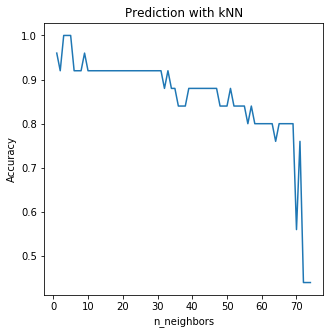

In [51]:
import matplotlib.pyplot as plt

#Plot accuracy
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.set_title("Prediction with kNN")
ax.set_xlabel("n_neighbors")
ax.set_ylabel("Accuracy")
ax.plot( prob_list[:, 0], prob_list[:, 1]);

## 【問題6】評価
検証用データの特徴量を入力して得られた推定値と、検証用データの正解値の近さを計算し、学習したモデルを評価します。

2値分類を評価するための指標値には accuracy、precision、recall、f値 があります。scikit-learnに用意されていますので、それぞれを計算してください。また、それぞれの意味について簡単に調査してマークダウンでまとめてください。

sklearn.metrics.accuracy_score — scikit-learn 0.20.2 documentation

sklearn.metrics.precision_score — scikit-learn 0.20.2 documentation

sklearn.metrics.recall_score — scikit-learn 0.20.2 documentation

sklearn.metrics.f1_score — scikit-learn 0.20.2 documentation

precision、recall、f値を計算する背景にはTrue Positive、True Negative、False Positive、False Negativeがあります。この4種類を計算し表示するものとして混合行列があります。これもscikit-learnを使い表示させてください。

sklearn.metrics.confusion_matrix — scikit-learn 0.20.2 documentation

In [52]:
#各々n_neighbor = 5で確認

#Accuracy: (tp + tn)/(tp + fp + fn + tn)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, nn_5)

1.0

In [53]:
#Precision: tp / (tp + fp)
from sklearn.metrics import precision_score
precision_score(y_test, nn_5)

1.0

In [54]:
#Recall: tp / (tp + fn)
from sklearn.metrics import recall_score
recall_score(y_test, nn_5)

1.0

In [55]:
#F-score: (precision*recall)/(precision + recall)
from sklearn.metrics import f1_score
f1_score(y_test, nn_5)

1.0

In [56]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, nn_5)

array([[11,  0],
       [ 0, 14]])

$$
Accuracy = \frac{(TP + TN)}{(TP + FP + FN + TN)}
$$

$$
Precision = \frac{(TP)}{(TP + FP)}
$$

$$
Recall = \frac{(TP)}{(TP + FN)}
$$

$$
F = \frac{(Precision \cdot Recall)}{(Precision + Recall)}
$$

定義から、Accuracy（正確度)は正誤の判定がどれくらい実際の答えと一致しているかを表す。  
Precision (精度)はPositiveと判断したデータの内実際にPositiveだったデータの比率を表す（陽性と判定したうち、どのくらいが実際陽性だったか）。  
Recall (回収率、再現率)は実際のPositiveデータの内、Positiveと判定したものの比率を表す（全ての陽性データのうち、どれくらいを実際に回収できたか）。

ただし、TP, FP, FN TNは以下を表す。下の表のようにまとめられる。Confusion matrixで求められる行列がこの表に相当する。
* True positive (TP, 真陽性） 予測で陽性と判定され、実際に陽性であるもの
* False negative (FN, 偽陰性） 予測では陰性と判定されるが、実際には陽性であるもの
* False positive (FP, 偽陽性） 予測では陽性と判定されるが、実際には陰性であるもの
* True negative (TN, 真陰性） 予測で陰性と判定され、実際に陰性であるもの  

| _ | _ | **Predicted Value** |  **Predicted Value**  |
|---|---|---|---|
| _ | _ | **Positive** | **Negative** |
|**Actual Value** | **Positive** | True Positive | False Negative |
|**Actual Value** | **Negative** | False Positive | True Negative |

## 【問題7】可視化
評価の一貫として可視化を行います。今回の場合2次元の特徴量で分類を行いましたから、散布図で可視化が可能です。どう分割するかという 決定領域 を描く関数を用意しました。これを利用して可視化を行ってください。可能であればより見やすく改良も行いましょう。
何をプロットするか

この例では学習データをプロットしたことでどのように学習したかを見ることができます。一方で、検証用データをプロットすればどういった特徴量のものが間違って分類されたかを見ることができます。また、両方合わせてプロットすることも可能です。いろいろと見てみるのが良いでしょう。

手法の改善
実際の問題では指標値や可視化を元に手法を改善していきますが、ここでは扱いません。

In [57]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def decision_region(X_train, y_train, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel',  target_names=['versicolor', 'virginica']):
    """
    ２値分類を２次元の特徴量で学習したモデルの決定領域を描く
    背景の色が学習したモデルによる推定値から描画される
    散布図の点は学習用のデータである。
    
    Parameters
    ---------------
    X_train: ndarray, shape(n_samples, 2)
        学習用データの特徴量
    y_train: ndarray, shape(n_samples,)
        学習用データの正解値
    model: object
        学習したモデルのインスタンスを入れる
    step: float, (default: 0.1)
        推定値を計算する間隔を設定する
    title: str
        グラフのタイトルの文章を与える
    xlabel, ylabel: str
        軸ラベルの文章を与える
    target_names=: list of str
        凡例の一覧を与える
    ---------------
    """
    #setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink','skyblue']
    n_class = 2
    
    #pred
    #各特徴量に対してメッシュを生成（a=(a1, a2, a3), b=(b1, b2, b3)に対して[[a1, b1], [a1, b2], [a1, b3]], [[a2, b1], [a2, b2], [a2, b3]], [[a3, b1], [a3, b2], [a3, b3]]を生成）
    mesh_f0, mesh_f1 = np.meshgrid(np.arange(np.min(X_train[:,0])-0.5, np.max(X_train[:,0])+0.5, step), np.arange(np.min(X_train[:,1])-0.5, np.max(X_train[:,1])+0.5, step))
    #多次元を一次元配列に
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    pred = model.predict(mesh).reshape(mesh_f0.shape)
    
    #plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #等高線塗りつぶし
    plt.contourf(mesh_f0, mesh_f1, pred, n_class-1, cmap=ListedColormap(contourf_color))
    #等高線塗りつぶし
    plt.contour(mesh_f0, mesh_f1, pred, n_class-1, colors='y', linewidths=3, alpha = 0.5)
    #重複しない要素に対して, 答えをプロット
    for i, target in enumerate(set(y_train)):
        plt.scatter(X_train[y_train==target][:, 0], X_train[y_train==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show

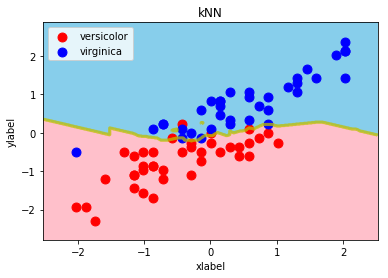

In [58]:
from sklearn.neighbors import KNeighborsClassifier
#kNN ( 3-nn)
#generate instance
nn_3 = KNeighborsClassifier(n_neighbors=3)
#learn by train data
learned_model_nn3 = nn_3.fit(X_train_z, y_train)

#Plot Train data
decision_region(X_train_z, y_train, learned_model_nn3, title='kNN')

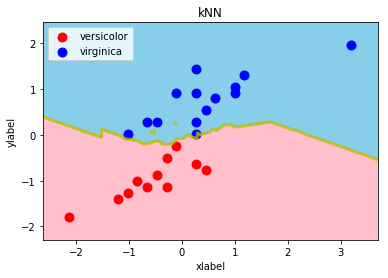

In [59]:
#Plot Test data
decision_region(X_test_z, y_test, learned_model_nn3, title='kNN')

## 【問題8】他の手法の学習
以下の全ての手法について学習・推定・評価・可視化を行ってください。そして、指標値を１つの表にまとめてください。その表と決定領域を利用して結果を簡単に考察してください。どの手法がどの指標値が良かったかや、どういった決定領域になっていたかを述べてください。

最近傍法
ロジスティック回帰
SVM
決定木
ランダムフォレスト
公式ドキュメントへのリンクは以下です。本来はそれぞれパラメータをチューニングするべきですが、まずはデフォルトで実行しましょう。

sklearn.neighbors.KNeighborsClassifier — scikit-learn 0.20.2 documentation
sklearn.linear_model.LogisticRegression — scikit-learn 0.20.2 documentation
sklearn.svm.SVC — scikit-learn 0.20.2 documentation
sklearn.tree.DecisionTreeClassifier — scikit-learn 0.20.2 documentation
sklearn.ensemble.RandomForestClassifier — scikit-learn 0.20.2 documentation

### 学習
[代表的な機械学習手法一覧 （Qiita）](https://qiita.com/tomomoto/items/b3fd1ec7f9b68ab6dfe2)

In [75]:
#最近傍法
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier()
learned_model_knn = clf_knn.fit(X_train_z, y_train)

#ロジスティック回帰
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression()
learned_model_lr = clf_lr.fit(X_train_z, y_train)

#SVM Classification (SVC)
from sklearn.svm import SVC
clf_svc = SVC(probability=True)
learned_model_svc = clf_svc.fit(X_train_z, y_train)

#決定木
from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier()
learned_model_dt = clf_dt.fit(X_train_z, y_train)

#ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()
learned_model_rf = clf_rf.fit(X_train_z, y_train)

/Users/ohmori/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ohmori/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### 推定

In [76]:
def predict_test(model, X_test):
    pred = model.predict(X_test)
    prob = model.predict_proba(X_test)
    return pred, prob

#最近傍法
print("KNN")
pred_knn, prob_knn = predict_test(learned_model_knn, X_test_z)
check_ans(pred_knn, y_test)

#ロジスティック回帰
print("\nLogistic Regression")
pred_lr, prob_lr = predict_test(learned_model_lr, X_test_z)
check_ans(pred_lr, y_test)

#SVM
print("\nSVM")
pred_svc, prob_svc = predict_test(learned_model_svc, X_test_z)
check_ans(pred_svc, y_test)

#決定木
print("\nDecision Tree")
pred_dt, prob_dt = predict_test(learned_model_dt, X_test_z)
check_ans(pred_dt, y_test)

#ランダムフォレスト
print("\nRandom Forest")
pred_rf, prob_rf = predict_test(learned_model_rf, X_test_z)
check_ans(pred_rf, y_test)

KNN
Predicted answer
 [2 1 1 1 2 1 1 2 1 2 2 2 1 2 1 2 2 1 1 2 2 2 2 2 1]
Correct answer
 [2 1 1 1 2 1 1 2 1 2 2 2 1 2 1 2 2 1 1 2 2 2 2 2 1]
T/F
 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
[ True] 
 [25]

Logistic Regression
Predicted answer
 [2 1 1 1 2 1 1 2 1 2 2 2 1 2 1 2 2 1 1 2 1 2 2 2 1]
Correct answer
 [2 1 1 1 2 1 1 2 1 2 2 2 1 2 1 2 2 1 1 2 2 2 2 2 1]
T/F
 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True]
[False  True] 
 [ 1 24]

SVM
Predicted answer
 [2 1 1 1 2 1 1 2 1 2 2 2 1 2 1 2 2 1 1 2 2 2 2 2 1]
Correct answer
 [2 1 1 1 2 1 1 2 1 2 2 2 1 2 1 2 2 1 1 2 2 2 2 2 1]
T/F
 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
[ True] 
 [25]

Decision Tree
Predicted 

### 評価

In [77]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

def print_model_evaluation(y_test, predicted_ans):
    print("Accuracy: %f " % accuracy_score(y_test, predicted_ans))
    print("Precision: %f" % precision_score(y_test, predicted_ans))
    print("Recall: %f" % recall_score(y_test, predicted_ans))
    print("F1-score: %f" % f1_score(y_test, predicted_ans))
    print("Confusion Matrix: ")
    print(confusion_matrix(y_test, predicted_ans))

#最近傍法
print("\nKNN")
print_model_evaluation(y_test, pred_knn)

#ロジスティック回帰
print("\nLogistic Regression")
print_model_evaluation(y_test, pred_lr)

#SVM
print("\nSVM")
print_model_evaluation(y_test, pred_svc)

#決定木
print("\nDecision Tree")
print_model_evaluation(y_test, pred_dt)

#ランダムフォレスト
print("\nRandom Forest")
print_model_evaluation(y_test, pred_rf)


KNN
Accuracy: 1.000000 
Precision: 1.000000
Recall: 1.000000
F1-score: 1.000000
Confusion Matrix: 
[[11  0]
 [ 0 14]]

Logistic Regression
Accuracy: 0.960000 
Precision: 0.916667
Recall: 1.000000
F1-score: 0.956522
Confusion Matrix: 
[[11  0]
 [ 1 13]]

SVM
Accuracy: 1.000000 
Precision: 1.000000
Recall: 1.000000
F1-score: 1.000000
Confusion Matrix: 
[[11  0]
 [ 0 14]]

Decision Tree
Accuracy: 0.880000 
Precision: 0.785714
Recall: 1.000000
F1-score: 0.880000
Confusion Matrix: 
[[11  0]
 [ 3 11]]

Random Forest
Accuracy: 0.960000 
Precision: 0.916667
Recall: 1.000000
F1-score: 0.956522
Confusion Matrix: 
[[11  0]
 [ 1 13]]


### 可視化
train, testデータそれぞれに対して可視化

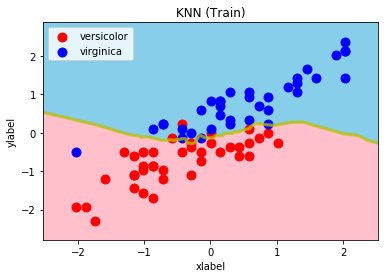

In [78]:
#最近傍法
decision_region(X_train_z, y_train, learned_model_knn, title='KNN (Train)')

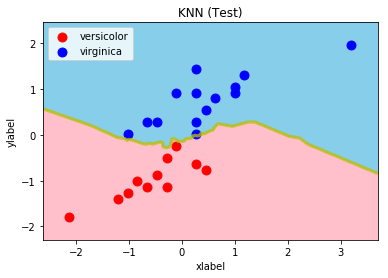

In [79]:
decision_region(X_test_z, y_test, learned_model_knn, title='KNN (Test)')

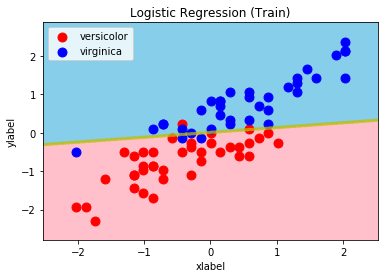

In [80]:
#ロジスティック回帰
decision_region(X_train_z, y_train, learned_model_lr, title='Logistic Regression (Train)')

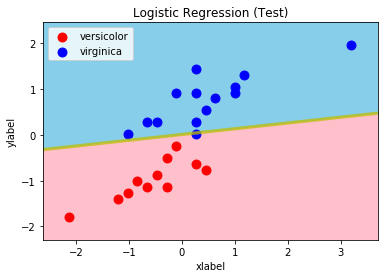

In [81]:
decision_region(X_test_z, y_test, learned_model_lr, title='Logistic Regression (Test)')

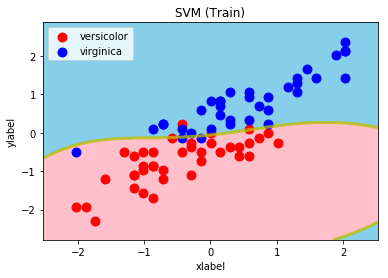

In [82]:
#SVM
decision_region(X_train_z, y_train, learned_model_svc, title='SVM (Train)')

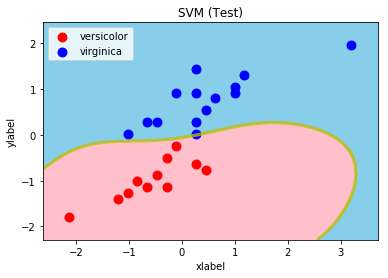

In [83]:
decision_region(X_test_z, y_test, learned_model_svc, title='SVM (Test)')

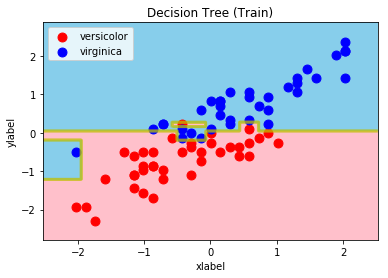

In [84]:
#決定木
decision_region(X_train_z, y_train, learned_model_dt, title='Decision Tree (Train)')

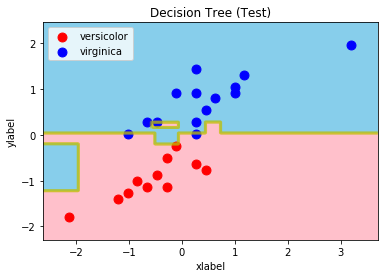

In [85]:
decision_region(X_test_z, y_test, learned_model_dt, title='Decision Tree (Test)')

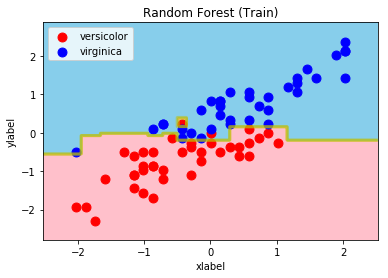

In [86]:
#ランダムフォレスト
decision_region(X_train_z, y_train, learned_model_rf, title='Random Forest (Train)')

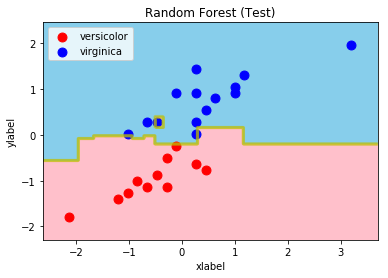

In [87]:
decision_region(X_test_z, y_test, learned_model_rf, title='Random Forest (Test)')

最近傍法はジグザグの線、Logistic Regressionは直線の区切り、決定木やRandom forestは四角形の集合のような区切り、SVMは円の集合のような区切りになった。今回の結果から見るとSVMとKNNが優れていた。

## 【問題9】（アドバンス課題）各パラメータの意味
手法のパラメータはデフォルトとしましたが、実際に利用する上ではデフォルトは必ずしも良い設定ではありません。それぞれの意味を調査した上で複数の設定を試し、その結果を報告してください。

実際の問題では？

パラメータチューニングと呼ばれる作業で、これにはグリッドサーチなどの方法が存在します。機械学習の上で重要な概念ですので、後々しっかりと扱うことになります。

## 【問題10】（アドバンス課題）標準化の有無の比較
前処理として標準化を行いましたが、これを行わなかった場合どのような結果が得られるでしょうか。各手法に対しての指標値の表と決定領域の図を作成し比較および考察を行ってください。考察には標準化が機械学習の前処理としてどのような意味があるかを絡めてください。

### 学習

In [104]:
#前処理後のX_train_zでなく、前処理前のX_trainを渡して検証

#最近傍法
from sklearn.neighbors import KNeighborsClassifier
clf_knn = KNeighborsClassifier()
learned_model_knn_no_preprocessing = clf_knn.fit(X_train, y_train)

#ロジスティック回帰
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression()
learned_model_lr_no_preprocessing = clf_lr.fit(X_train, y_train)

#SVM Classification (SVC)
from sklearn.svm import SVC
clf_svc = SVC(probability=True)
learned_model_svc_no_preprocessing = clf_svc.fit(X_train, y_train)

#決定木
from sklearn.tree import DecisionTreeClassifier
clf_dt = DecisionTreeClassifier()
learned_model_dt_no_preprocessing = clf_dt.fit(X_train, y_train)

#ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()
learned_model_rf_no_preprocessing = clf_rf.fit(X_train, y_train)

/Users/ohmori/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/ohmori/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/ohmori/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


### 推定

In [105]:
#最近傍法
print("KNN")
pred_knn_npp, prob_knn_npp = predict_test(learned_model_knn_no_preprocessing, X_test)
check_ans(pred_knn_npp, y_test)

#ロジスティック回帰
print("\nLogistic Regression")
pred_lr_npp, prob_lr_npp = predict_test(learned_model_lr_no_preprocessing, X_test)
check_ans(pred_lr_npp, y_test)

#SVM
print("\nSVM")
pred_svc_npp, prob_svc_npp = predict_test(learned_model_svc_no_preprocessing, X_test)
check_ans(pred_svc_npp, y_test)

#決定木
print("\nDecision Tree")
pred_dt_npp, prob_dt_npp = predict_test(learned_model_dt_no_preprocessing, X_test)
check_ans(pred_dt_npp, y_test)

#ランダムフォレスト
print("\nRandom Forest")
pred_rf_npp, prob_rf_npp = predict_test(learned_model_rf_no_preprocessing, X_test)
check_ans(pred_rf_npp, y_test)

KNN
Predicted answer
 [2 1 1 1 2 1 1 2 1 2 2 2 1 2 1 2 2 1 1 2 2 2 2 2 1]
Correct answer
 [2 1 1 1 2 1 1 2 1 2 2 2 1 2 1 2 2 1 1 2 2 2 2 2 1]
T/F
 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
[ True] 
 [25]

Logistic Regression
Predicted answer
 [2 1 1 1 2 1 1 2 1 2 2 2 1 2 1 2 2 1 1 2 1 2 2 2 1]
Correct answer
 [2 1 1 1 2 1 1 2 1 2 2 2 1 2 1 2 2 1 1 2 2 2 2 2 1]
T/F
 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True]
[False  True] 
 [ 1 24]

SVM
Predicted answer
 [2 1 1 1 2 1 1 2 1 2 2 2 1 2 1 2 2 1 1 2 1 2 2 2 1]
Correct answer
 [2 1 1 1 2 1 1 2 1 2 2 2 1 2 1 2 2 1 1 2 2 2 2 2 1]
T/F
 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True  True
  True]
[False  True] 
 [ 1 24]

Decision Tree
P

### 評価

In [106]:

#最近傍法
print("\nKNN")
print_model_evaluation(y_test, pred_knn_npp)

#ロジスティック回帰
print("\nLogistic Regression")
print_model_evaluation(y_test, pred_lr_npp)

#SVM
print("\nSVM")
print_model_evaluation(y_test, pred_svc_npp)

#決定木
print("\nDecision Tree")
print_model_evaluation(y_test, pred_dt_npp)

#ランダムフォレスト
print("\nRandom Forest")
print_model_evaluation(y_test, pred_rf_npp)


KNN
Accuracy: 1.000000 
Precision: 1.000000
Recall: 1.000000
F1-score: 1.000000
Confusion Matrix: 
[[11  0]
 [ 0 14]]

Logistic Regression
Accuracy: 0.960000 
Precision: 0.916667
Recall: 1.000000
F1-score: 0.956522
Confusion Matrix: 
[[11  0]
 [ 1 13]]

SVM
Accuracy: 0.960000 
Precision: 0.916667
Recall: 1.000000
F1-score: 0.956522
Confusion Matrix: 
[[11  0]
 [ 1 13]]

Decision Tree
Accuracy: 0.920000 
Precision: 0.846154
Recall: 1.000000
F1-score: 0.916667
Confusion Matrix: 
[[11  0]
 [ 2 12]]

Random Forest
Accuracy: 1.000000 
Precision: 1.000000
Recall: 1.000000
F1-score: 1.000000
Confusion Matrix: 
[[11  0]
 [ 0 14]]


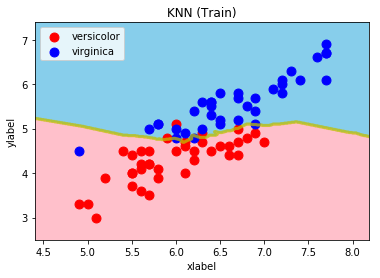

In [107]:
decision_region(X_train, y_train, learned_model_knn_no_preprocessing, title='KNN (Train)')

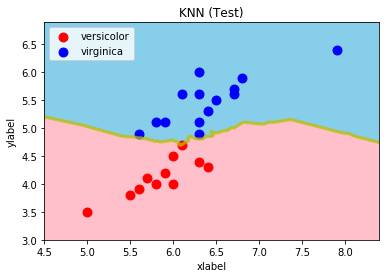

In [108]:
decision_region(X_test, y_test, learned_model_knn_no_preprocessing, title='KNN (Test)')

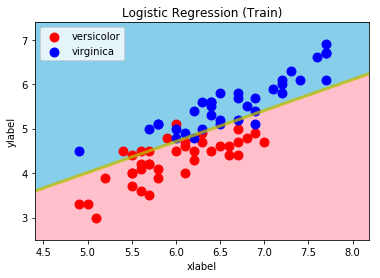

In [109]:
decision_region(X_train, y_train, learned_model_lr_no_preprocessing, title='Logistic Regression (Train)')

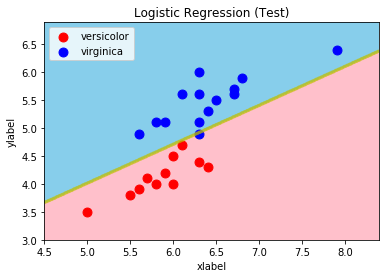

In [110]:
decision_region(X_test, y_test, learned_model_lr_no_preprocessing, title='Logistic Regression (Test)')

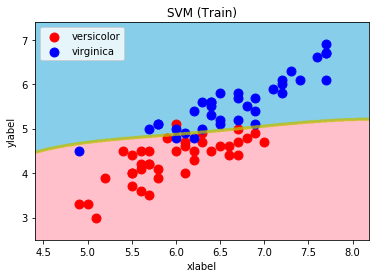

In [111]:
decision_region(X_train, y_train, learned_model_svc_no_preprocessing, title='SVM (Train)')

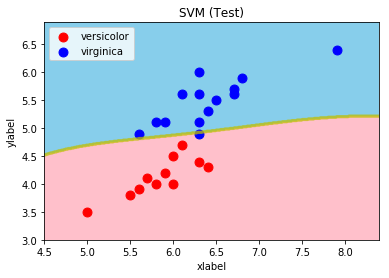

In [112]:
decision_region(X_test, y_test, learned_model_svc_no_preprocessing, title='SVM (Test)')

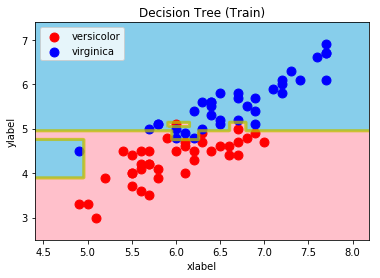

In [113]:
decision_region(X_train, y_train, learned_model_dt_no_preprocessing, title='Decision Tree (Train)')

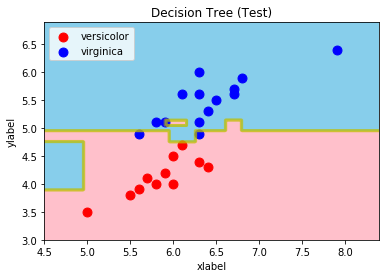

In [114]:
decision_region(X_test, y_test, learned_model_dt_no_preprocessing, title='Decision Tree (Test)')

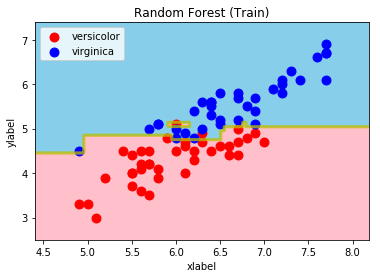

In [115]:
decision_region(X_train, y_train, learned_model_rf_no_preprocessing, title='Random Forest (Train)')

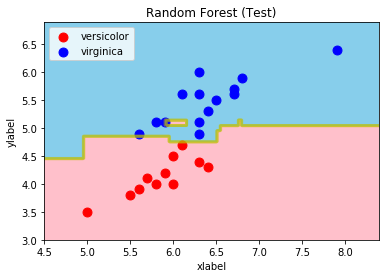

In [116]:
decision_region(X_test, y_test, learned_model_rf_no_preprocessing, title='Random Forest (Test)')

スケールが異なる特徴量同士の基準を揃えるために標準化をすると考えられる。今回特徴量として用いたのは、sepal_lengthとpetal_lengthであり共に単位がcmであり、絶対値としてもそれほど差がない特徴量同士だった。そのためか、標準化をせずに分類しても精度としてはそれほど変わらなかった。

## 【問題11】（アドバンス課題）全ての目的変数を使用して精度が高い手法
ここまではアヤメの種類を減らし2値分類を行ってきましたが、3種類全てを使った多値分類を行います。学習と推定、評価を行って、最も精度の高い手法を探してください。

ロジスティック回帰やSVMは2値分類を基本とした手法で、多値分類には工夫が必要ですが、scikit-learnでは意識せず動作させることができます。しかし、指標値precision、recall、f値はライブラリのパラメータをデフォルトから変更する必要があります。マイクロ平均やマクロ平均という考え方を使いますので、これについて調査して説明をまとめましょう。

また、決定領域を可視化する場合は前述の関数を適切に書き換える必要があります。以下が出力例です。